#**W2D1 Tutorial 2: Time series, global averages, and scenario comparison**

> Indented block

> Indented block




**Week 2, Day 1, Future Climate: The Physical Basis**

**Content creators:** Brodie Pearson (Day Lead), Julius Busecke (Tutorial co-lead), Tom Nicholas (Tutorial co-lead)

**Content reviewers:** Jenna Pearson, Ohad Zivan

**Content editors:** TBD

**Production editors:** TBD

**Our 2023 Sponsors:** TBD

#**Tutorial Objectives**

Today's tutorials demonstrate how to work with data from *Earth System Models* (ESMs) simulations conducted for the recent *Climate Model Intercomparison Project* (CMIP6) 

By the end of today's tutorials you will be able to:

*   Manipulate raw data from multiple CMIP6 models
*   Evaluate the spread of future projections from several CMIP6 models
*   Synthesize climate data from observations and models



#**Setup**

    



In [ ]:
#Imports

!pip install condacolab &> /dev/null        
import condacolab
condacolab.install()

# Install all packages in one call (+ use mamba instead of conda)
# hopefully this improves speed
!mamba install xarray-datatree intake-esm gcsfs xmip aiohttp nc-time-axis cf_xarray xarrayutils &> /dev/null

✨🍰✨ Everything looks OK!


In [ ]:
import time
tic = time.time()

import intake
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

from xmip.preprocessing import combined_preprocessing
from xarrayutils.plotting import shaded_line_plot

from datatree import DataTree
from xmip.postprocessing import _parse_metric


ModuleNotFoundError: ignored

In [ ]:
# @title Figure settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle")
# model_colors = {k:f"C{ki}" for ki, k in enumerate(source_ids)}


In [ ]:
# @title Plotting functions

# You may have functions that plot results that aren't 
# particularly interesting. You can add these here to hide them. 

def plotting_z(z):
  """This function multiplies every element in an array by a provided value

  Args:
    z (ndarray): neural activity over time, shape (T, ) where T is number of timesteps
  
   """

  fig, ax = plt.subplots()

  ax.plot(z)
  ax.set(
      xlabel='Time (s)',
      ylabel='Z',
      title='Neural activity over time'
      )



In [ ]:
# @title Helper functions

# If any helper functions you want to hide for clarity (that has been seen before
# or is simple/uniformative), add here
# If helper code depends on libraries that aren't used elsewhere,
# import those libaries here, rather than in the main import cell


## **Tutorial 2: Time series, global averages, and scenario comparison**



In [ ]:
# @title Video 1: Video 1 Name 
#Tech team will add code to format and display the video

##**Section 2.1: Load CMIP6 SST data from several models using xarray**

Let's expand on Tutorial 1 by loading five different CMIP6 models on last week's Climate Modelling day.



In [ ]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json") # open an intake catalog containing the Pangeo CMIP cloud data

# pick our five example models
# There are many more to test out! Try executing `col.df['source_id'].unique()` to get a list of all available models
source_ids = ['IPSL-CM6A-LR', 'GFDL-ESM4', 'ACCESS-CM2', 'MPI-ESM1-2-LR', 'TaiESM1']

## **If the following cell crashes, run the cell a second time**

In [ ]:
# from the full `col` object, create a subset using facet search
cat = col.search(
    source_id=source_ids,
    variable_id='tos',
    member_id='r1i1p1f1',
    table_id='Omon',
    grid_label='gn',
    experiment_id = ['historical', 'ssp126', 'ssp585'],
    require_all_on = ['source_id'] #make sure that we only get models which have all of the above experiments
)

# convert the sub-catalog into a datatree object, by opening each dataset into an xarray.Dataset (without loading the data)
kwargs = dict(
    preprocess=combined_preprocessing, #apply xMIP fixes to each dataset
    xarray_open_kwargs=dict(use_cftime=True), #ensure all datasets use the same time index
    storage_options={'token':'anon'} #anonymous/public authentication to google cloud storage
)
# hopefully we can implement https://github.com/intake/intake-esm/issues/562 before the 
# actual tutorial, so this would be a lot cleaner
cat.esmcat.aggregation_control.groupby_attrs = ['source_id', 'experiment_id']
dt = cat.to_datatree(**kwargs)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'source_id/experiment_id'


###**Coding Exercise 2.1: Load additional CMIP6 data sets**

In the following tutorials we will be looking at the global mean sea surface temperature. To calculate this global mean, will need to know the horizontal area of every ocean grid cell in all the models we are using. 

Write code to load this ocean-grid area data using the previously shown method for SST data, noting that:
* We now need a variable called *areacello* (area of cells in the ocean) 
* This variable is stored in table_id *Ofx* (it is from the ocean model and is fixed/constant in time) 
* A model's grid does not change between experiments so you only need to get grid data from the *historical* experiment for each model


In [ ]:
#################################################
## TODO for students: details of what they should do ##
# Fill out function and remove
raise NotImplementedError("Student exercise: load the ocean-grid area data from the 5 CMIP6 models using the information above")
#################################################

cat_area = col.search(
    source_id=source_ids,
    # Add the appropriate variable_id
    variable_id=...,
    member_id='r1i1p1f1',
    # Add the appropriate table_id
    table_id=...,
    grid_label='gn',
    # Add the appropriate experiment_id
    experiment_id = [...],
    require_all_on = ['source_id']
)
# hopefully we can implement https://github.com/intake/intake-esm/issues/562 before the 
# actual tutorial, so this would be a lot cleaner
cat_area.esmcat.aggregation_control.groupby_attrs = ['source_id', 'experiment_id']
dt_area = cat_area.to_datatree(**kwargs)

dt_with_area = DataTree()

for model,subtree in dt.items():
    metric = dt_area[model]['historical'].ds['areacello']
    dt_with_area[model] = subtree.map_over_subtree(_parse_metric,metric)

NotImplementedError: ignored

In [ ]:
# to_remove solution
cat_area = col.search(
    source_id=source_ids,
    # Add the appropriate variable_id
    variable_id='areacello',
    member_id='r1i1p1f1',
    # Add the appropriate table_id
    table_id='Ofx',
    grid_label='gn',
    # Add the appropriate experiment_id
    experiment_id = ['historical'],
    require_all_on = ['source_id']
)
# hopefully we can implement https://github.com/intake/intake-esm/issues/562 before the 
# actual tutorial, so this would be a lot cleaner
cat_area.esmcat.aggregation_control.groupby_attrs = ['source_id', 'experiment_id']
dt_area = cat_area.to_datatree(**kwargs)

dt_with_area = DataTree()

for model,subtree in dt.items():
    metric = dt_area[model]['historical'].ds['areacello']
    dt_with_area[model] = subtree.map_over_subtree(_parse_metric,metric)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'source_id/experiment_id'


###**Coding Exercise 2.2: Calculate and plot projected global mean sea surface temperature**

The data files above contain spatial maps of the sea surface temperature for every month of each experiment's time period. For the rest of today's tutorials, we're going to focus on the global mean sea surface temperature, rather than maps, as a way to visualize the ocean's changing temperature at a global scale*.

Complete the following code so that it calculates and plots a timeseries of global mean sea surface temperature from the *TaiESM1* model for both the historical experiment and the two future projection experiments, SSP1-2.6 (low emissions) and SSP5-8.5 (high emissions). 

As you complete this exercise this, consider the following questions:
* In the first function, what *xarray* operation is the following line doing, and why is it neccessary?
```
return ds.weighted(ds.areacello.fillna(0)).mean(['x', 'y'], keep_attrs=True)
```
* How would your time series plot might change if you instead used took a simple mean of all the sea surface temperatures across all grid cells? (Perhaps your previous maps could provide some help here) 



**Note: we could alternatively look at ocean heat content, which depends on temperature at all depths, but it is a more intensive computation that would take too long to calculate in these tutorials.*

In [ ]:
#################################################
## TODO for students: details of what they should do ##
# Fill out function and remove
raise NotImplementedError("Student exercise: Calculate the global mean of each model, experiment, and time")
#################################################
%matplotlib inline

def global_mean(ds:xr.Dataset) -> xr.Dataset:
    """Global average, weighted by the cell area"""
    return ds.weighted(ds.areacello.fillna(0)).mean(['x', 'y'], keep_attrs=True) 

# average every dataset in the tree globally
dt_gm = dt_with_area.map_over_subtree(...)

for experiment in ['historical', 'ssp126', 'ssp585']:
    da = dt_gm['TaiESM1'][experiment].ds.tos
    da.plot(label=experiment)
plt.title('Global Mean SST from TaiESM1')
plt.ylabel('Global Mean SST [$^\circ$C]')
plt.xlabel('Year')
plt.legend()

plt.show()

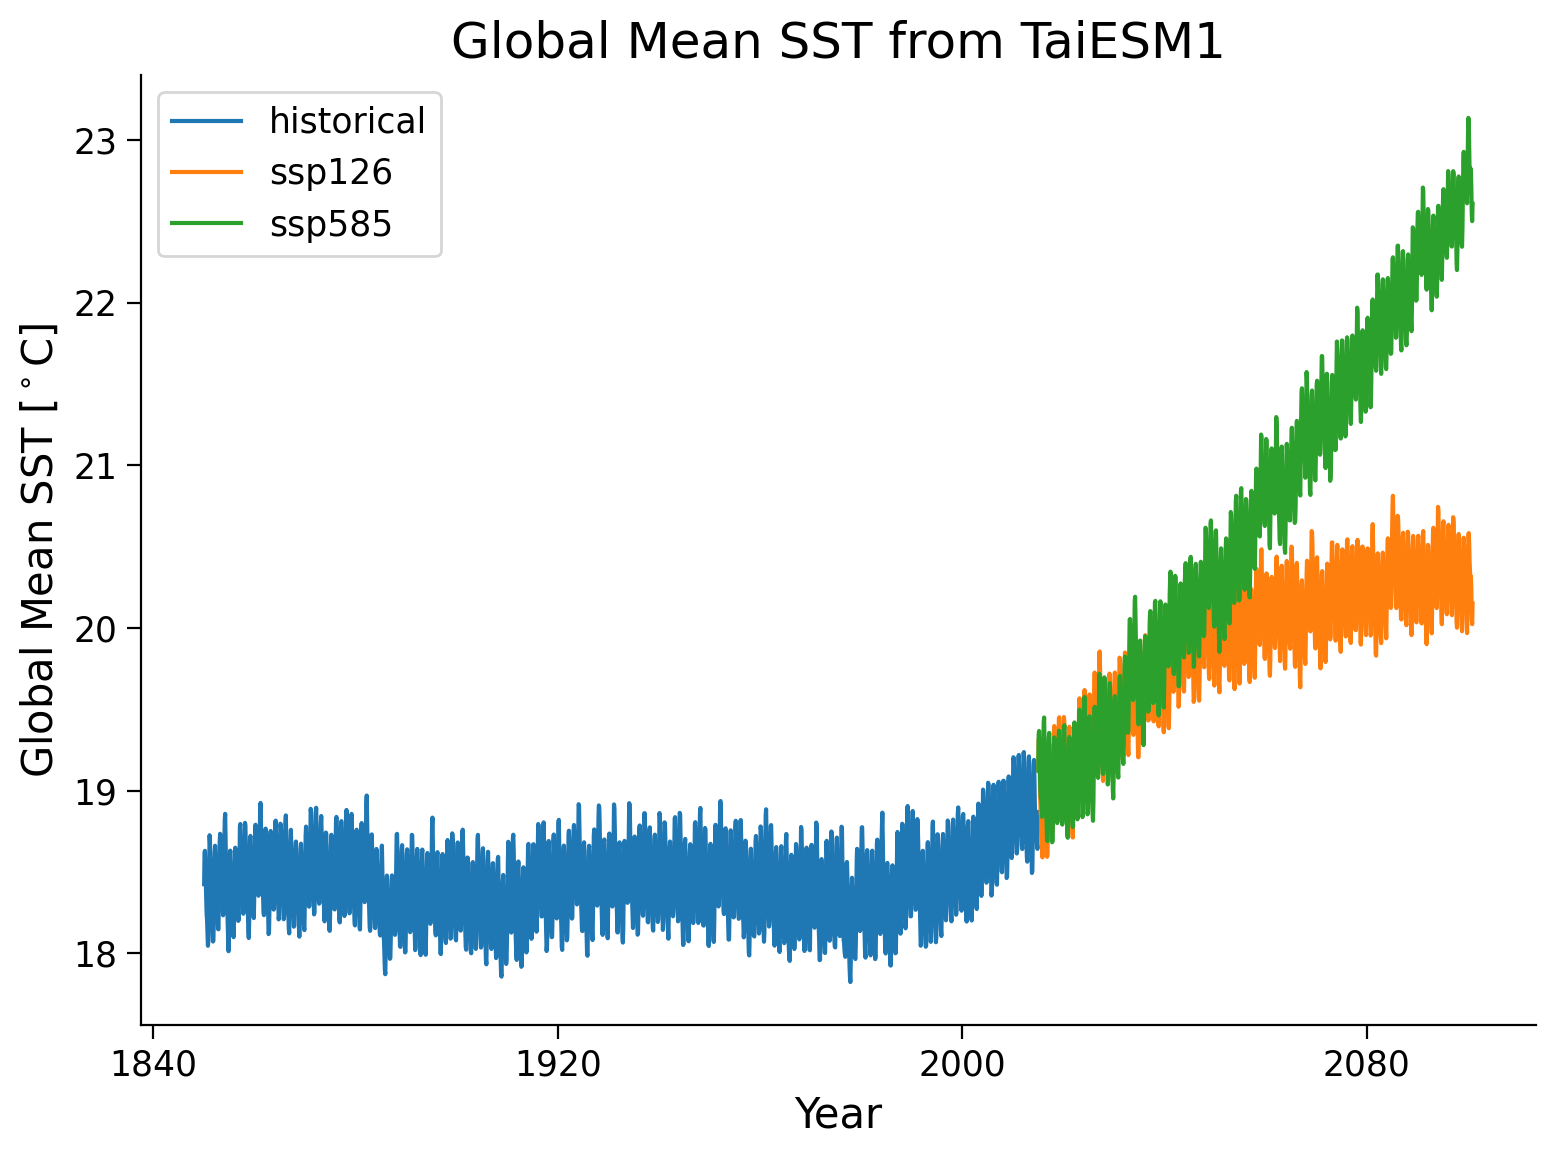

In [ ]:
# to_remove solution
%matplotlib inline

def global_mean(ds:xr.Dataset) -> xr.Dataset:
    """Global average, weighted by the cell area"""
    return ds.weighted(ds.areacello.fillna(0)).mean(['x', 'y'], keep_attrs=True) 

# average every dataset in the tree globally
dt_gm = dt_with_area.map_over_subtree(global_mean)

for experiment in ['historical', 'ssp126', 'ssp585']:
    da = dt_gm['TaiESM1'][experiment].ds.tos
    da.plot(label=experiment)
plt.title('Global Mean SST from TaiESM1')
plt.ylabel('Global Mean SST [$^\circ$C]')
plt.xlabel('Year')
plt.legend()

with plt.xkcd():
  plt.show()

## Post-figure questions

1.   What do you think is interesting about this plot? 
2.   Does anything in the plot surprise you?
3.   Do you find this plot easy to read? (BONUS TASK: If you do not find it easy to read, try improving this plot to address this)

